In [32]:
# Make sure you are running under a virtual environment
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [33]:
import gdown
gdown.download("https://drive.google.com/file/d/1Z3RNNc8Hqa3KYIGCuYpp0Ubgfx5-1DYC/view?usp=drive_link", "dataset.zip", fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1Z3RNNc8Hqa3KYIGCuYpp0Ubgfx5-1DYC
To: /home/amit/runi-bigdata-2024/dataset.zip
100%|██████████| 20.6M/20.6M [00:01<00:00, 12.8MB/s]


'dataset.zip'

In [34]:
!unzip dataset.zip

Archive:  dataset.zip
replace AirPollutionSeoul/Measurement_summary.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

## Question 1

The dataset source can be found here:
https://www.kaggle.com/datasets/bappekim/air-pollution-in-seoul/data


In [36]:
measurement_info=pd.read_csv("AirPollutionSeoul/Original Data/Measurement_info.csv")
measurement_info.head()

,Measurement date,Station code,Item code,Average value,Instrument status
0,2017-01-01 00:00,101,1,0.004,0
1,2017-01-01 00:00,101,3,0.059,0
2,2017-01-01 00:00,101,5,1.200,0
3,2017-01-01 00:00,101,6,0.002,0
4,2017-01-01 00:00,101,8,73.000,0


In [37]:
measurement_item_info=pd.read_csv("AirPollutionSeoul/Original Data/Measurement_item_info.csv")
measurement_item_info.head()

,Item code,Item name,Unit of measurement,Good(Blue),Normal(Green),Bad(Yellow),Very bad(Red)
0,1,SO2,ppm,0.02,0.05,0.15,1.0
1,3,NO2,ppm,0.03,0.06,0.20,2.0
2,5,CO,ppm,2.00,9.00,15.00,50.0
3,6,O3,ppm,0.03,0.09,0.15,0.5
4,8,PM10,Mircrogram/m3,30.00,80.00,150.00,600.0


In [38]:
measurement_station_info=pd.read_csv("AirPollutionSeoul/Original Data/Measurement_station_info.csv")
measurement_station_info.head()

,Station code,Station name(district),Address,Latitude,Longitude
0,101,Jongno-gu,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008
1,102,Jung-gu,"15, Deoksugung-gil, Jung-gu, Seoul, Republic o...",37.564263,126.974676
2,103,Yongsan-gu,"136, Hannam-daero, Yongsan-gu, Seoul, Republic...",37.540033,127.004850
3,104,Eunpyeong-gu,"215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...",37.609823,126.934848
4,105,Seodaemun-gu,"32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...",37.593742,126.949679


## Question 2

In order to allow for insightful analysis in an effient manner, we decided to create a big dataset containing all the fields from the 3 CSV datasets joined together. This will allow us later on to utilize cassandra's CQL strengths, without the need to JOIN the data.

A pre-joined schema for the air pollution measurements in Seoul dataset will look as follows:

### Measurement Data Table

This table stores the air pollution measurements. Queries on this table are likely to be based on date, station code, and item code.

- **Table Name**: `measurement_joined`
- **Primary Key**:, 
  - **Partition Key**: `station_code`, `item_code`
  - **Clustering Key**: `measurement_date`
- **Columns**:
  - `measurement_date` (timestamp)
  - `station_code` (int)
  - `item_code` (int)
  - `average_value` (float)
  - `instrument_status` (int)
  - `item_name` (text)
  - `unit_of_measurement` (text)
  - `good_blue` (float)
  - `normal_green` (float)
  - `bad_yellow` (float)
  - `very_bad_red` (float)
  - `station_name` (text)
  - `address` (text)
  - `latitude` (float)
  - `longitude` (float)

This schema will efficiently support queries filtering by a specific station, pollutant item, and then ordering or filtering further by date.


## Question 3


In [39]:
# Kill any running previous instance
! docker kill ex1_cassandra || true

# Setting up cassandra instance using docker with local persistent storage under the persistent_data folder.
# The cassandra.yaml file is also mounted to the container to allow for configuration changes.
! docker run --rm -d --name ex1_cassandra -p 9042:9042 -v `pwd`/cassandra.yaml:/etc/cassandra/cassandra.yaml -v `pwd`/persistent_data:/var/lib/cassandra cassandra 

ex1_cassandra
5db62a738c2f6ab10b8f327d9e7421dfc87fbb8c91451de85559433895b6f4d1


In [42]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.query import SimpleStatement

# Setup Cassandra Connection
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()


In [43]:

# Create Keyspace and Tables

session.execute("""
    CREATE KEYSPACE IF NOT EXISTS ex1_keyspace WITH replication = {
        'class': 'SimpleStrategy', 'replication_factor': '3'
    }
""")

session.set_keyspace('ex1_keyspace')

session.execute("""
    CREATE TABLE IF NOT EXISTS measurement_joined (
        station_code int,
        measurement_date timestamp,
        item_code int,
        average_value float,
        instrument_status int,
        
        item_name text,
        unit_of_measurement text,
        good_blue float,
        normal_green float,
        bad_yellow float,
        very_bad_red float,
                
        station_name text,
        address text,
        latitude float,
        longitude float,
        
        PRIMARY KEY ((station_code, item_code), measurement_date)
    )
""")


In [44]:
# Setting the batch size so that we can control the number of rows inserted per batch
batch_size = 1024*25 # 25KB

In [45]:
# Ingestion of measurement_item_info
pollutent_info = dict()

def clean_and_transform_measurement_item_info(df):
    df['Item code'] = df['Item code'].astype(int)
    df['Item name'] = df['Item name'].astype(str)
    df['Unit of measurement'] = df['Unit of measurement'].astype(str)
    df['Good(Blue)'] = df['Good(Blue)'].astype(float)
    df['Normal(Green)'] = df['Normal(Green)'].astype(float)
    df['Bad(Yellow)'] = df['Bad(Yellow)'].astype(float)
    df['Very bad(Red)'] = df['Very bad(Red)'].astype(float)
    return df

measurement_item_info_normalized = clean_and_transform_measurement_item_info(measurement_item_info)
for index, row in measurement_item_info_normalized.iterrows():
    pollutent_info[row['Item code']] = dict(
        item_name=row['Item name'], 
        unit_of_measurement=row['Unit of measurement'], 
        good_blue=row['Good(Blue)'], 
        normal_green=row['Normal(Green)'], 
        bad_yellow=row['Bad(Yellow)'], 
        very_bad_red=row['Very bad(Red)']
    )

In [46]:
# Ingestion of measurement_station_info
station_info = dict()

def clean_and_transform_measurement_station_info(df):
    df['Station code'] = df['Station code'].astype(int)
    df['Station name(district)'] = df['Station name(district)'].astype(str)
    df['Address'] = df['Address'].astype(str)
    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)
    return df

measurement_station_info_normalized = clean_and_transform_measurement_station_info(measurement_station_info)

for index, row in measurement_station_info_normalized.iterrows():
    station_info[row['Station code']] = dict(
        station_name=row['Station name(district)'], 
        address=row['Address'], 
        latitude=row['Latitude'], 
        longitude=row['Longitude']
    )

station_info

{101: {'station_name': 'Jongno-gu',
  'address': '19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea',
  'latitude': 37.5720164,
  'longitude': 127.0050075},
 102: {'station_name': 'Jung-gu',
  'address': '15, Deoksugung-gil, Jung-gu, Seoul, Republic of Korea',
  'latitude': 37.5642629,
  'longitude': 126.9746757},
 103: {'station_name': 'Yongsan-gu',
  'address': '136, Hannam-daero, Yongsan-gu, Seoul, Republic of Korea',
  'latitude': 37.540032700000005,
  'longitude': 127.00485},
 104: {'station_name': 'Eunpyeong-gu',
  'address': '215, Jinheung-ro, Eunpyeong-gu, Seoul, Republic of Korea',
  'latitude': 37.6098232,
  'longitude': 126.9348476},
 105: {'station_name': 'Seodaemun-gu',
  'address': '32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul, Republic of Korea',
  'latitude': 37.5937421,
  'longitude': 126.9496787},
 106: {'station_name': 'Mapo-gu',
  'address': '10, Poeun-ro 6-gil, Mapo-gu, Seoul, Republic of Korea',
  'latitude': 37.5555803,
  'longitude': 126.9055975},
 107:

In [47]:

# Ingestion of measurement_info

def clean_and_transform_measurement_info(df):
    df['Measurement date'] = pd.to_datetime(df['Measurement date'])
    df['Station code'] = df['Station code'].astype(int)
    df['Item code'] = df['Item code'].astype(int)
    df['Average value'] = df['Average value'].astype(float)
    df['Instrument status'] = df['Instrument status'].astype(int)
    return df

measurement_info_normalized = clean_and_transform_measurement_info(measurement_info)

insert_stmt_measurement_info = session.prepare("""
    INSERT INTO measurement_joined (
        station_code, 
        measurement_date, 
        item_code, 
        average_value, 
        instrument_status, 
        item_name, 
        unit_of_measurement, 
        good_blue, 
        normal_green, 
        bad_yellow, 
        very_bad_red, 
        station_name, 
        address, 
        latitude, 
        longitude
    ) VALUES (
        ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?
    );
""")

batch = BatchStatement()
for index, row in measurement_info_normalized.iterrows():
    station = station_info[row['Station code']]
    pollutent = pollutent_info[row["Item code"]]
    batch.add(insert_stmt_measurement_info, (
        row['Station code'], 
        row['Measurement date'], 
        row['Item code'], 
        row['Average value'], 
        row['Instrument status'],
        pollutent["item_name"],
        pollutent["unit_of_measurement"],
        pollutent["good_blue"],
        pollutent["normal_green"],
        pollutent["bad_yellow"],
        pollutent["very_bad_red"],
        station["station_name"],
        station["address"],
        station["latitude"],
        station["longitude"]))
    if index % batch_size == 0:
        session.execute(batch)
        batch.clear()

session.execute(batch)


# Question 4

Starting a `cqlsh` session on the instance:
`docker exec -it ex1_cassandra cqlsh`

Applying the keyspace:
`use ex1_keyspace`

# TODO: showcase more queries with joins (not sure we should do joins in cassandra db logic)

In [59]:
# A query for retrieving the the average_value measured for a specific item code (pollutant) in a specific time range
rows = session.execute("""
SELECT item_name, measurement_date, average_value
FROM measurement_joined
WHERE item_code = 3
AND measurement_date >= '2019-01-01 00:00:00' AND measurement_date <= '2019-12-01 00:00:00'
GROUP BY station_code, item_code, measurement_date
ALLOW FILTERING
""")
print(pd.DataFrame(list(rows)))

       item_name    measurement_date  average_value
0            NO2 2019-01-01 01:00:00          0.062
1            NO2 2019-01-01 02:00:00          0.062
2            NO2 2019-01-01 03:00:00          0.052
3            NO2 2019-01-01 04:00:00          0.048
4            NO2 2019-01-01 05:00:00          0.043
...          ...                 ...            ...
191231       NO2 2019-11-30 20:00:00          0.053
191232       NO2 2019-11-30 21:00:00          0.041
191233       NO2 2019-11-30 22:00:00          0.032
191234       NO2 2019-11-30 23:00:00          0.029
191235       NO2 2019-12-01 00:00:00          0.029

[191236 rows x 3 columns]


In [68]:
# calculate the maximum average_value for each combination of station_code, item_code, measurement_date
rows = session.execute("""
SELECT item_code, MAX(average_value) AS max_average_value
FROM measurement_joined
GROUP BY station_code, item_code, measurement_date
""")
print(pd.DataFrame(list(rows)))

         item_code  max_average_value
0                6              0.003
1                6              0.003
2                6              0.003
3                6              0.003
4                6              0.003
...            ...                ...
3885061          9             15.000
3885062          9             16.000
3885063          9             15.000
3885064          9             16.000
3885065          9             13.000

[3885066 rows x 2 columns]


In [98]:
# calculate the average average_value pollution Level for a specific pollutant for each station_code in a date limit
rows = session.execute("""
SELECT station_code, item_code, AVG(average_value) 
FROM measurement_joined 
WHERE item_code = 3 AND measurement_date >= '2019-01-01 00:00:00' AND measurement_date <= '2019-12-01 00:00:00'
GROUP BY station_code, item_code
ALLOW FILTERING;
""")
print(pd.DataFrame(list(rows)))

    station_code  item_code  system_avg_average_value
0            109          3                 -0.041837
1            115          3                  0.029920
2            116          3                  0.028491
3            104          3                 -0.002292
4            101          3                  0.029355
5            106          3                 -0.043740
6            112          3                  0.017841
7            125          3                  0.027420
8            121          3                 -0.033838
9            124          3                  0.030728
10           110          3                  0.000325
11           107          3                  0.030781
12           119          3                  0.030597
13           118          3                  0.029866
14           113          3                  0.016381
15           105          3                  0.020644
16           114          3                  0.023101
17           102          3 

In [119]:
# count the measurements exceeding a threshold for a specific pollutant
rows = session.execute("""
SELECT COUNT(*)
FROM measurement_joined 
WHERE item_code = 6 AND average_value > 0.7
ALLOW FILTERING;
""")
print(pd.DataFrame(list(rows)))

   count
0     11


In [145]:
# get the latest measurement date of a specific pollutant 
rows = session.execute("""
SELECT MAX(measurement_date) as latest_date
FROM measurement_joined
WHERE item_code = 3
ALLOW FILTERING;
""")
print(pd.DataFrame(list(rows)))

          latest_date
0 2019-12-31 23:00:00


## Question 5

# TODO: add more queries with joins
# TODO: The current Query daily average air quality is not good since it refers to the measurment_info table

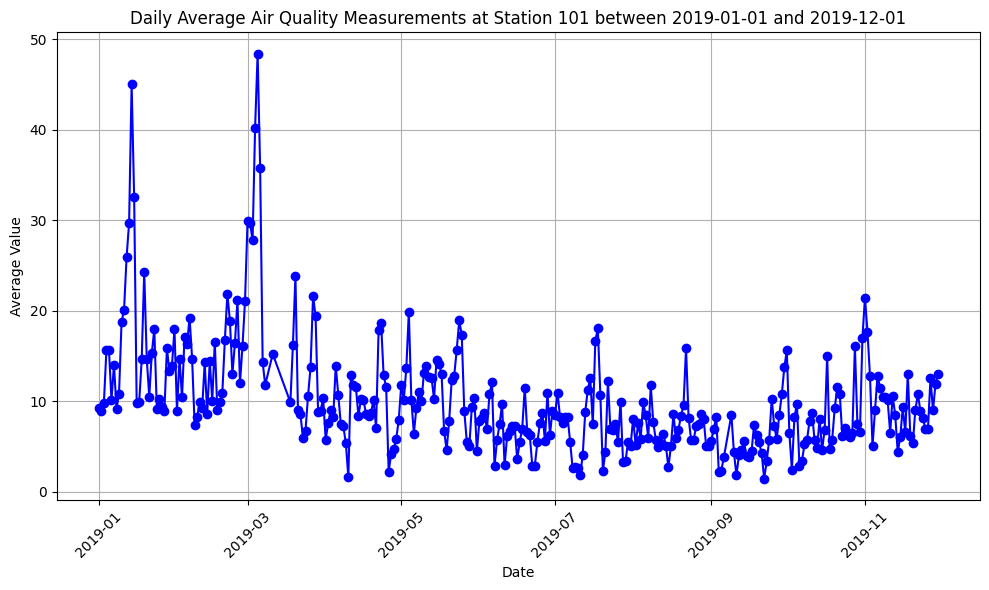

In [74]:

# Query daily average air quality measurements at station 101 between 2019-01-01 and 2019-12-01
query = """
SELECT measurement_date, average_value FROM measurement_info 
WHERE station_code = 101 AND measurement_date >= '2019-01-01 00:00:00' 
AND measurement_date < '2019-12-01 00:00:00';
"""
statement = SimpleStatement(query, fetch_size=None)
rows = session.execute(statement)
df = pd.DataFrame(list(rows))

# Convert measurement_date to a date (without time) for daily aggregation
df['measurement_date'] = pd.to_datetime(df['measurement_date']).dt.date

# Aggregate by date to get daily average
daily_avg = df.groupby('measurement_date')['average_value'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_avg['measurement_date'], daily_avg['average_value'], marker='o', linestyle='-', color='b')
plt.title('Daily Average Air Quality Measurements at Station 101 between 2019-01-01 and 2019-12-01')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

In [156]:
# showcase a map with all the locations where a pollutant item was viewed
query = """
SELECT latitude, longitude
FROM measurement_joined 
WHERE item_code = 6
ALLOW FILTERING;
"""

rows = session.execute(query)

unique_coordinates = set()

# Iterate through the rows and filter out duplicates
for row in rows:
    lat_lon = (row.latitude, row.longitude)
    unique_coordinates.add(lat_lon)

# Calculate the map center
map_center = [
    sum(lat for lat, lon in unique_coordinates) / len(unique_coordinates),
    sum(lon for lat, lon in unique_coordinates) / len(unique_coordinates),
]

m = folium.Map(location=map_center, zoom_start=12)

# Add markers for unique coordinates
for coord in unique_coordinates:
    folium.Marker(location=coord, popup=str(coord)).add_to(m)

# Display the map
display(m)

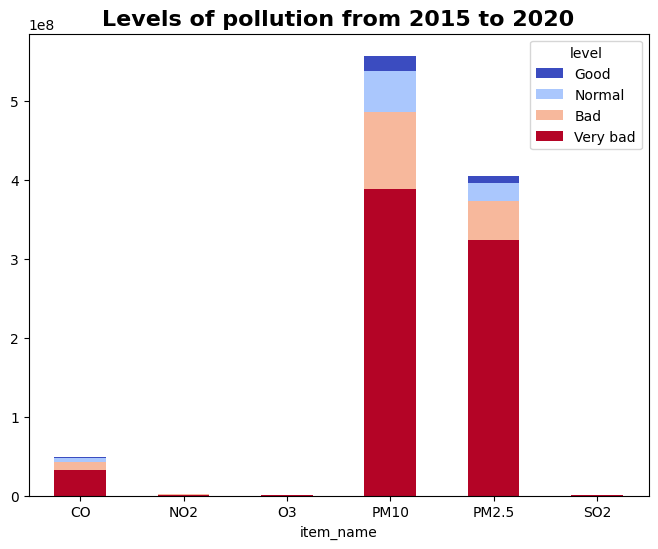

In [175]:
##Showcase the level of pollution for each item, between 2015 to 2020 relative on the different pollution levels
rows = session.execute("""
SELECT item_name, good_blue, normal_green, bad_yellow, very_bad_red
FROM measurement_joined 
WHERE measurement_date >= '2015-01-01 00:00:00' 
  AND measurement_date <= '2020-12-31 23:59:59'
  ALLOW FILTERING;
""")
df = pd.DataFrame(rows)

categories = {
    "good_blue": "Good",
    "normal_green": "Normal",
    "bad_yellow": "Bad",
    "very_bad_red": "Very bad"
}

# Reshaping the data to have a single column for level and value
df_melted = df.melt(id_vars=["item_name"], var_name="level", value_name="value")
df_melted["level"] = df_melted["level"].map(categories)

# Counting the number of occurrences for each pollution level and item
level_counts = df_melted.groupby(["item_name", "level"])["value"].sum().unstack()

level_counts = level_counts[['Very bad', 'Bad', 'Normal', 'Good']]

ax = level_counts.plot(kind='bar', stacked=True, figsize=(8,6), rot=0,
                       colormap='coolwarm_r', legend='reverse')
plt.title('Levels of pollution from 2015 to 2020', fontsize=16, fontweight='bold')
plt.show()

## Question 6

# TODO: this question
